Importing libraries and data files

In [31]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings 
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 20)

/kaggle/input/janatahack-crosssell-prediction/train.csv
/kaggle/input/janatahack-crosssell-prediction/test.csv
/kaggle/input/janatahack-crosssell-prediction/sample_submission.csv


In [32]:
train = pd.read_csv('/kaggle/input/janatahack-crosssell-prediction/train.csv',index_col=0)
test = pd.read_csv('/kaggle/input/janatahack-crosssell-prediction/test.csv',index_col=0)
sample_submission = pd.read_csv('/kaggle/input/janatahack-crosssell-prediction/sample_submission.csv',index_col=0)

In [33]:
train[['Driving_License','Previously_Insured','Policy_Sales_Channel']] = train[['Driving_License','Previously_Insured','Policy_Sales_Channel']].astype('object')
train['Response'] = train['Response'].astype('object')

test[['Driving_License','Previously_Insured','Policy_Sales_Channel']] = test[['Driving_License','Previously_Insured','Policy_Sales_Channel']].astype('object')

In [34]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152,39,0


Data pre-processing

In [35]:
test.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152,53
381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7,111
381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124,199
381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152,187
381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152,297


In [36]:
X = train.drop(['Response','Policy_Sales_Channel'],axis=1)
test = test.drop('Policy_Sales_Channel',axis=1)
y = train['Response'].values

In [37]:
X = pd.get_dummies(X,drop_first=True)
test = pd.get_dummies(test,drop_first=True)

In [38]:
le = LabelEncoder()
y = le.fit_transform(y)

Training the model

In [28]:
rfc = RandomForestClassifier()
rfc.fit(X,y)
roc_auc_score(y,rfc.predict_proba(X)[:,1])

0.9999998331602332

In [39]:
rfc = RandomForestClassifier()
rfc.fit(X,y)
roc_auc_score(y,rfc.predict_proba(X)[:,1])

0.9999891959086953

In [25]:
rffeature_importances = pd.DataFrame(rfc.feature_importances_,index=X.columns.to_list(),columns=['importance'])
rffeature_importances.sort_values(by='importance',ascending=False,inplace=True)

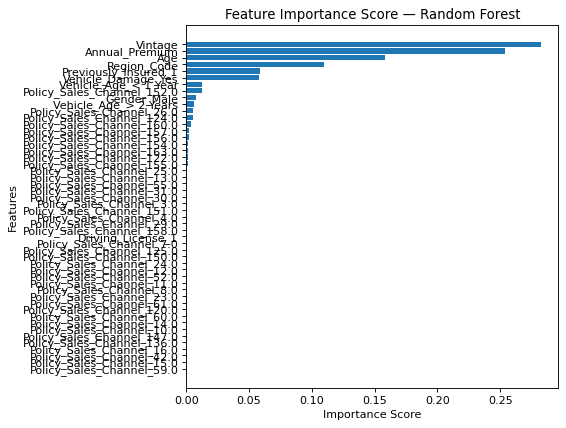

In [26]:
num = min([50,len(list(X.columns))])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = rffeature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(rffeature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(6,6), dpi=80, facecolor='w', edgecolor='k')
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score — Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

In [ ]:
X 

In [ ]:
clf = LGBMClassifier(n_estimators=550,
                     learning_rate=0.03,
                     min_child_samples=40,
                     random_state=1,
                     colsample_bytree=0.5,
                     reg_alpha=2,
                     reg_lambda=2)

clf.fit(X, y, verbose=50,eval_metric = 'auc')

In [ ]:
lgb_pred = clf.predict_proba(X)[:,1]
roc_auc_score(y,lgb_pred)

Pre-processing test data and predicting probabilities

In [40]:
print(test.shape,X.shape)

missing_cols = set(X.columns) - set(test.columns)
for c in missing_cols:
    test[c] = 0

print(test.shape,X.shape)

#keeping the order of columns same for X and test
test = test[X.columns]

(127037, 10) (381109, 10)
(127037, 10) (381109, 10)


In [41]:
test_pred = rfc.predict_proba(test)[:,1]

In [ ]:
sample_submission['Response'] = test_pred
sample_submission.to_csv('Submission_v3.csv')

Hyperparameter tuning 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2020, stratify=y)

In [ ]:
#Preparing learning rate shrinkage
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [ ]:
#Using test subset for early stopping
import lightgbm as lgb
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [ ]:
#Setup hyperparameter search
from scipy.stats import uniform as sp_uniform
from scipy.stats import randint as sp_randint
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

In [ ]:
#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [ ]:
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [ ]:
opt_parameters = {'colsample_bytree': 0.5284213741879101, 'min_child_samples': 125, 'min_child_weight': 10.0, 'num_leaves': 22, 'reg_alpha': 0.1, 'reg_lambda': 20, 'subsample': 0.3080033455431848} 

In [ ]:
best_params = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.5284213741879101,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 125,
 'min_child_weight': 10.0,
 'min_split_gain': 0.0,
 'n_estimators': 5000,
 'n_jobs': 4,
 'num_leaves': 22,
 'objective': 'binary',
 'random_state': 314,
 'reg_alpha': 0.1,
 'reg_lambda': 20,
 'silent': True,
 'subsample': 0.3080033455431848,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'None'}

In [ ]:
clf_final = lgb.LGBMClassifier(**best_params)
# clf_final = lgb.LGBMClassifier(**gs.best_estimator_.get_params())

In [ ]:
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)])

In [ ]:
probabilities = clf_final.predict_proba(test)[:,1]
sample_submission['Response'] = probabilities
sample_submission.to_csv('Submission_v2.csv')